<a href="https://colab.research.google.com/github/pabloknappo/hello-world/blob/main/notebooks/bearing_fault_classification/bearing_fault_classification_2DConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bearing fault classfication

In [ ]:
! pip3 install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00


In [ ]:
! sudo apt install msttcorefonts -qq
! rm ~/.cache/matplotlib -rf

The following additional packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ubuntu-advantage-tools ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils
Suggested packages:
  shunit2 python3-launchpadlib
The following NEW packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-update-manager python3-yaml
  ttf-mscorefonts-installer ubuntu-advantage-tools
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils
0 upgraded, 17 newly installed, 0 to remove and 15 not upgraded.
Need to get 1,516 kB of archives.
After this operation, 6,335 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like pr

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
#import tensorflow_addons as tfa

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams["font.size"] = 10

In [ ]:
#check the tensorflow version and available devices
print("Tensorflow version: " + tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensorflow version: 2.12.0
GPU is available


In [ ]:
! git clone https://github.com/pabloknappo/spectrogram_learning/

Cloning into 'spectrogram_learning'...
remote: Enumerating objects: 13826, done.
remote: Counting objects: 100% (1227/1227), done.
remote: Compressing objects: 100% (1219/1219), done.
remote: Total 13826 (delta 10), reused 1223 (delta 6), pack-reused 12599
Receiving objects: 100% (13826/13826), 2.92 GiB | 28.77 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (14967/14967), done.
Error downloading object: measurements_22022022/bearing_dataset_len_fs.csv (39adc26): Smudge error: Error downloading measurements_22022022/bearing_dataset_len_fs.csv (39adc26facdfa936c446970f75d5b9ab4d7c792e94963e2aad60aab8f3aabc52): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/spectrogram_learning/.git/lfs/logs/20230707T115649.922972649.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: measurements_220220

In [ ]:
! ls

sample_data  spectrogram_learning


In [ ]:
#get to the directory with images
#path = os.path.join(os.getcwd(),'spectrogram_learning','data')
path = os.path.join(os.getcwd(),'spectrogram_learning','measurements_2903','3_faults')

In [ ]:
#change current directory
os.chdir('/content')

In [ ]:
print(path)
! ls

/content/spectrogram_learning/measurements_2903/3_faults
sample_data  spectrogram_learning


In [ ]:
data_dir = path

#image format data
IMG_HEIGHT = 160
IMG_WIDTH = 160
IMG_SIZE = (160, 160)

#set batch size
BATCH_SIZE = 32


In [ ]:

#create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2397 files belonging to 3 classes.
Using 1918 files for training.


In [ ]:
#create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 2397 files belonging to 3 classes.
Using 479 files for validation.


In [ ]:
class_names = train_ds.class_names

num_classes = len(class_names)

print(class_names)

['inner race fault', 'no fault', 'outter race fault']


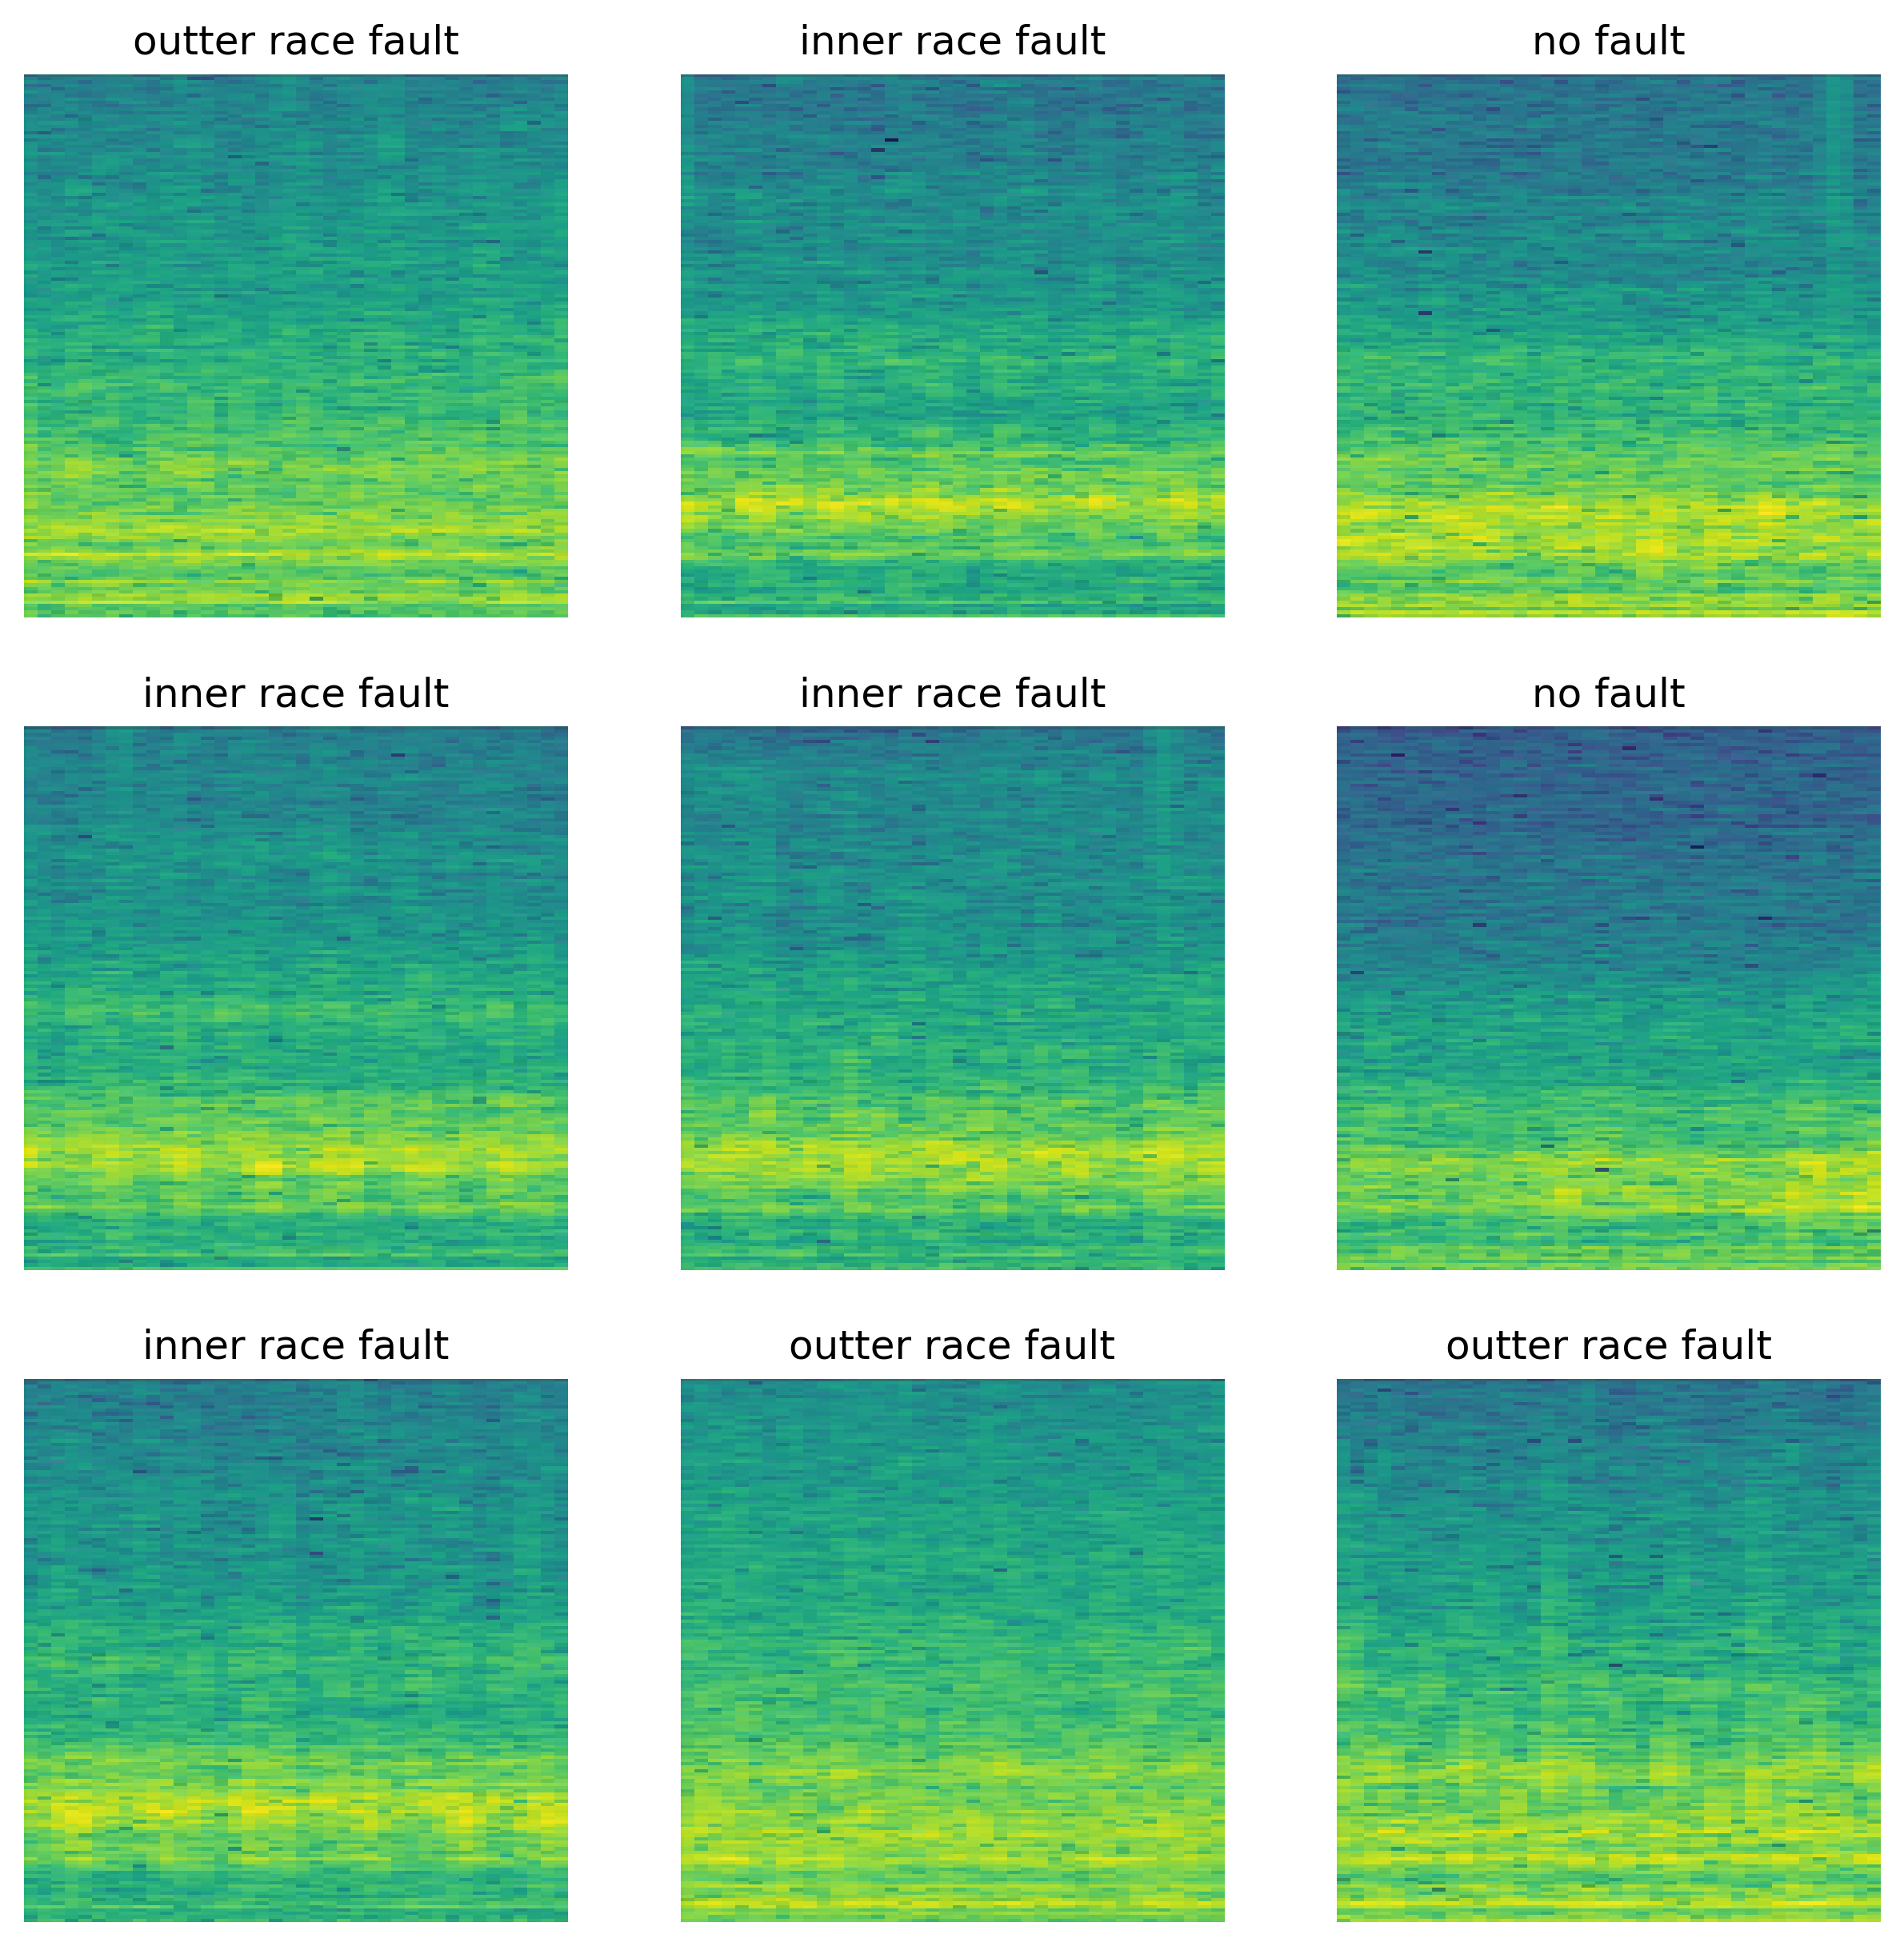

In [ ]:
#visualize the data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.savefig('spektrogramy_macierz.png')
plt.savefig('spektrogramy_macierz.pdf')
plt.savefig('spektrogramy_macierz.tiff')

In [ ]:
#create a test dataset as a 1/5 part of validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 3


In [ ]:
#

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#rescale expected values from [0,255] to [-1,1]

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#freeeze conv layers
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
#add classification head

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = tf.keras.layers.Softmax()(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
 model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
"""
## Train the model
"""

from tensorflow import keras

epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.1, patience=5, min_lr=0.000001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1),
]

from tensorflow.keras.optimizers import SGD
opt = SGD()

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/500
60/60 [==============================] - 23s 276ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.7028 - val_loss: 0.2429 - val_sparse_categorical_accuracy: 0.9661 - lr: 0.0100
Epoch 2/500
60/60 [==============================] - 18s 257ms/step - loss: 0.2345 - sparse_categorical_accuracy: 0.9411 - val_loss: 0.1805 - val_sparse_categorical_accuracy: 0.9582 - lr: 0.0100
Epoch 3/500
60/60 [==============================] - 19s 289ms/step - loss: 0.1690 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.0990 - val_sparse_categorical_accuracy: 0.9948 - lr: 0.0100
Epoch 4/500
60/60 [==============================] - 16s 242ms/step - loss: 0.1369 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.0842 - val_sparse_categorical_accuracy: 1.0000 - lr: 0.0100
Epoch 5/500
60/60 [==============================] - 16s 245ms/step - loss: 0.1102 - sparse_categorical_accuracy: 0.9818 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9896 - lr: 0.0100
Epoch 6/500
60/60 [======

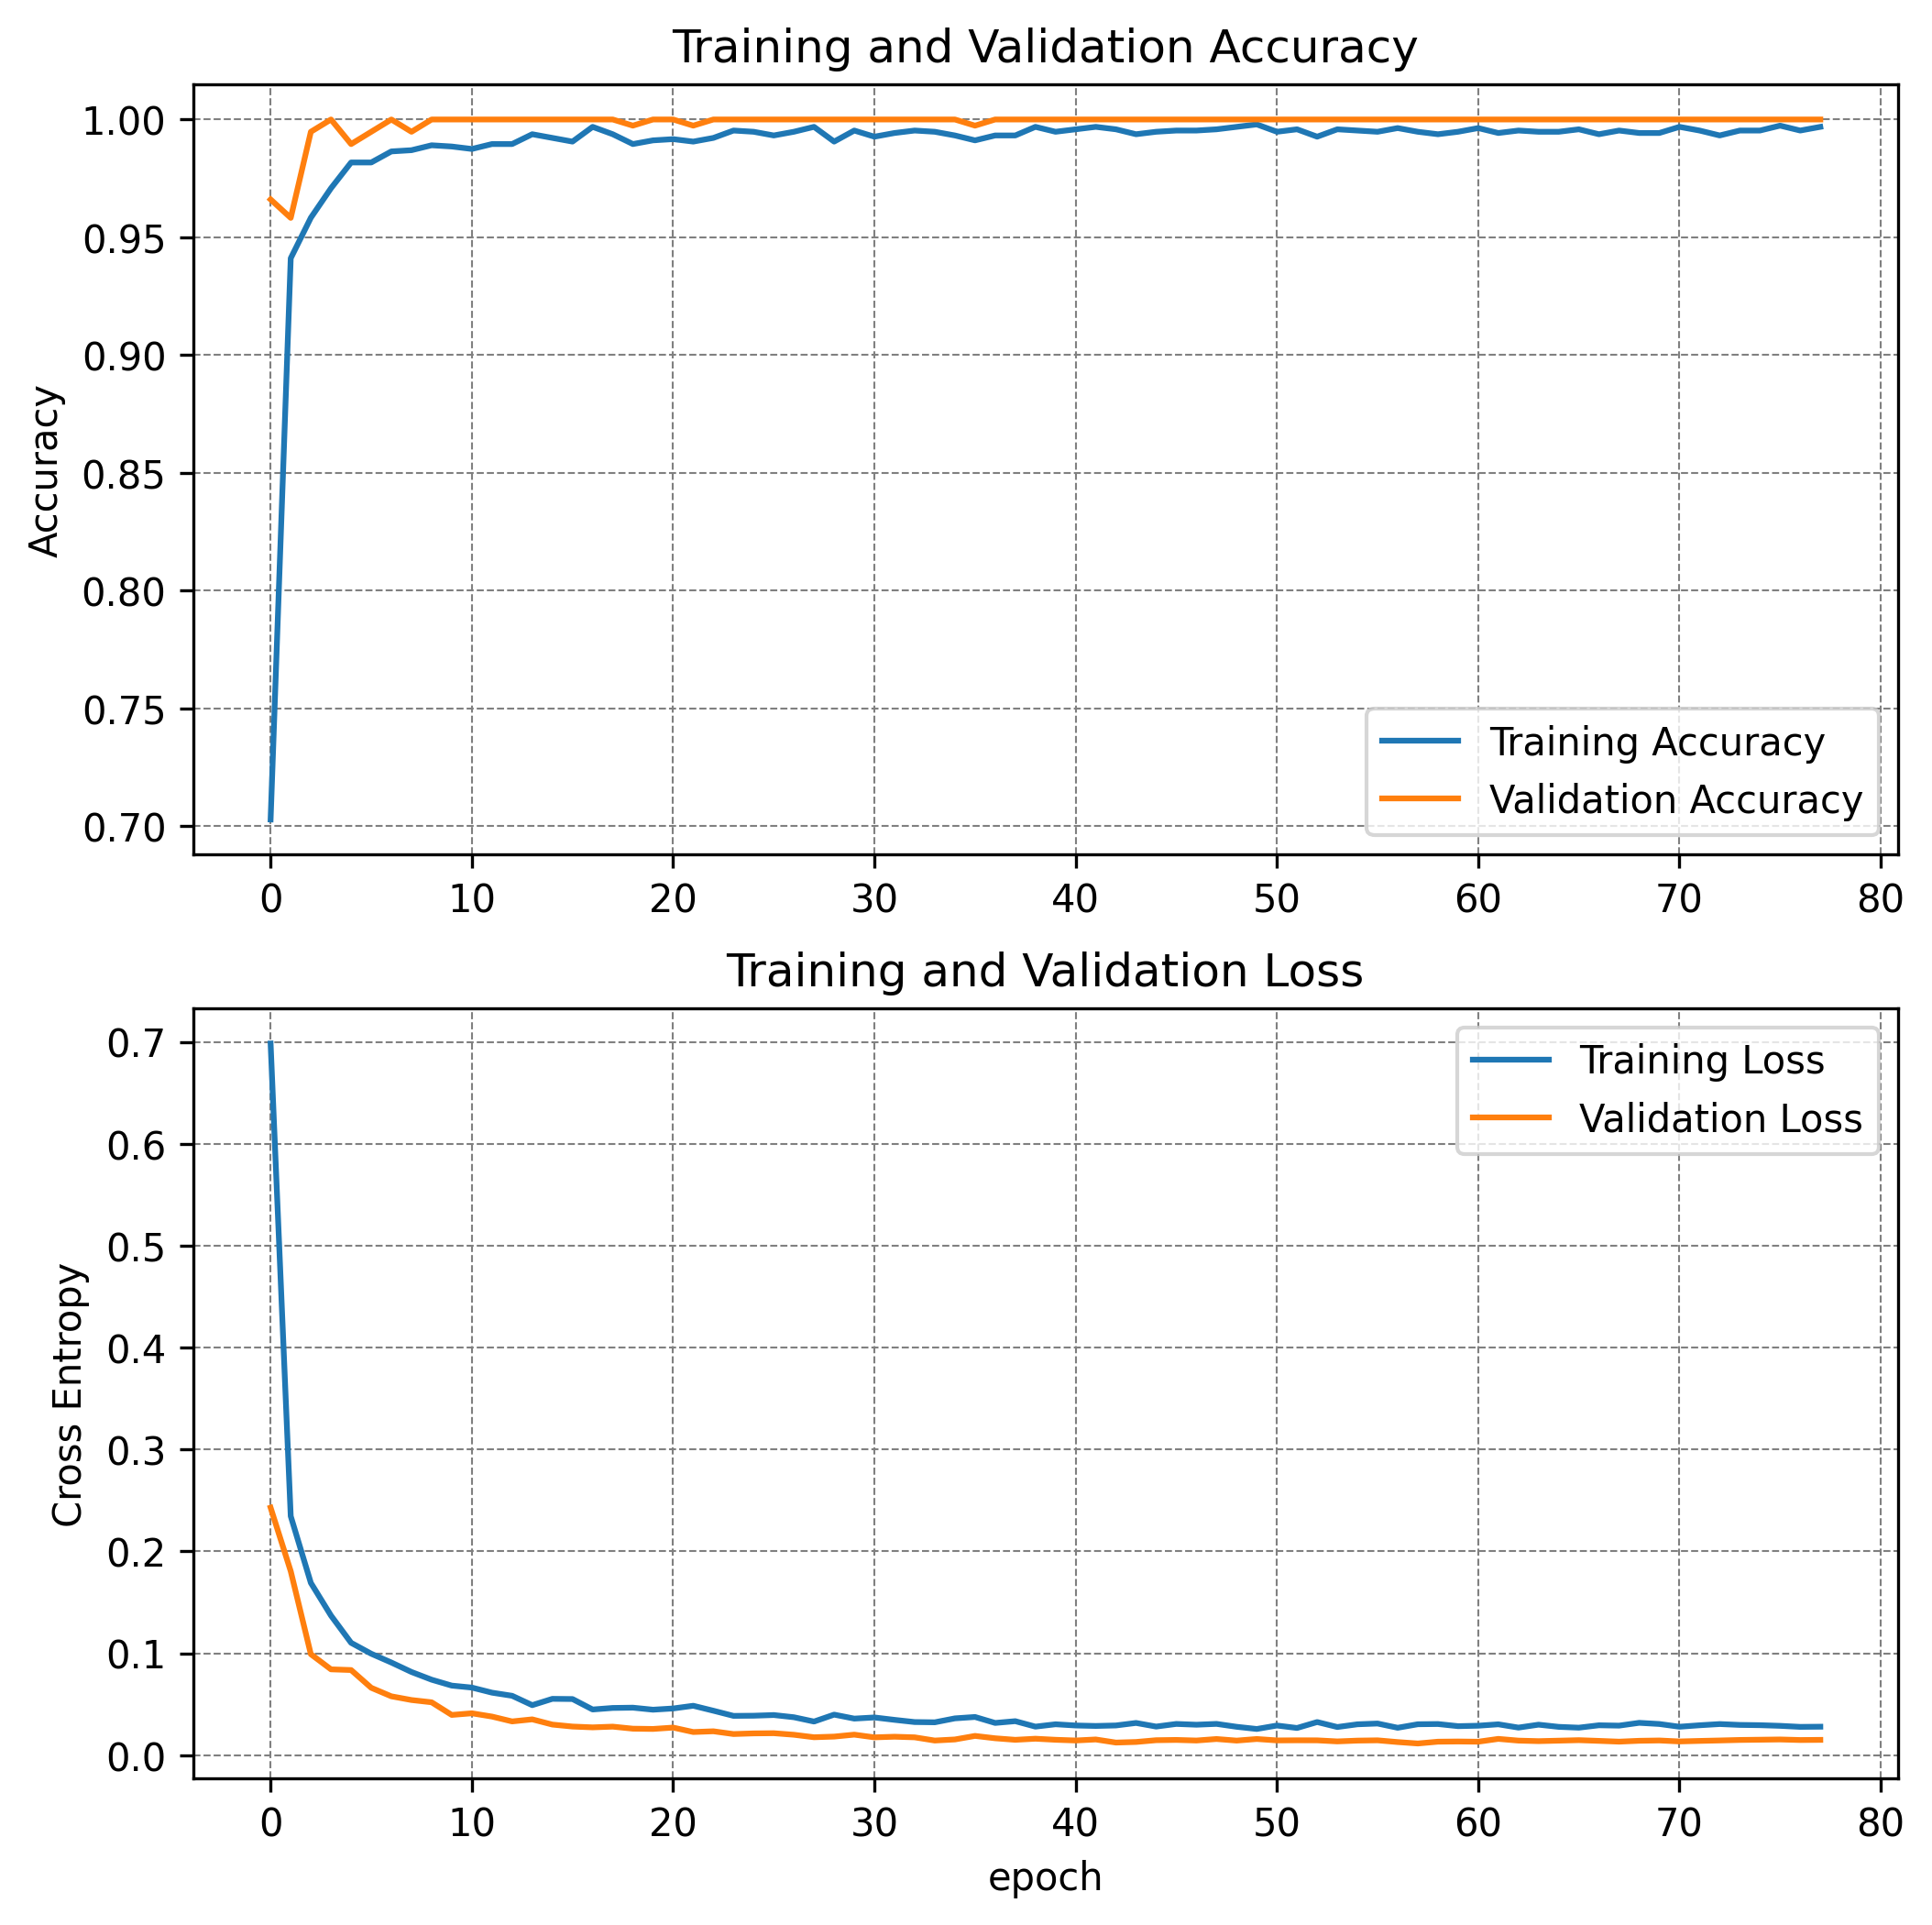

In [ ]:
acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.savefig('uczenie_wykres.png')
plt.show()

In [ ]:
import pandas as pd


image_batch, label_batch = test_ds.as_numpy_iterator().next()
print('Image batch shape: ', image_batch.shape)
predictions = model.predict_on_batch(image_batch)
print('Prediction results shape:', predictions.shape)

# Convert prediction results to Pandas dataframe, for better visualization
tf_pred_dataframe = pd.DataFrame(predictions)
tf_pred_dataframe.columns = class_names

Image batch shape:  (32, 160, 160, 3)
Prediction results shape: (32, 3)


In [ ]:
tf_pred_dataframe.head()

inner race fault  no fault  outter race fault
0          0.999722  0.000277       5.772019e-07
1          0.999561  0.000415       2.338558e-05
2          0.000411  0.997620       1.968961e-03
3          0.999457  0.000541       1.863639e-06
4          0.994904  0.004655       4.406190e-04

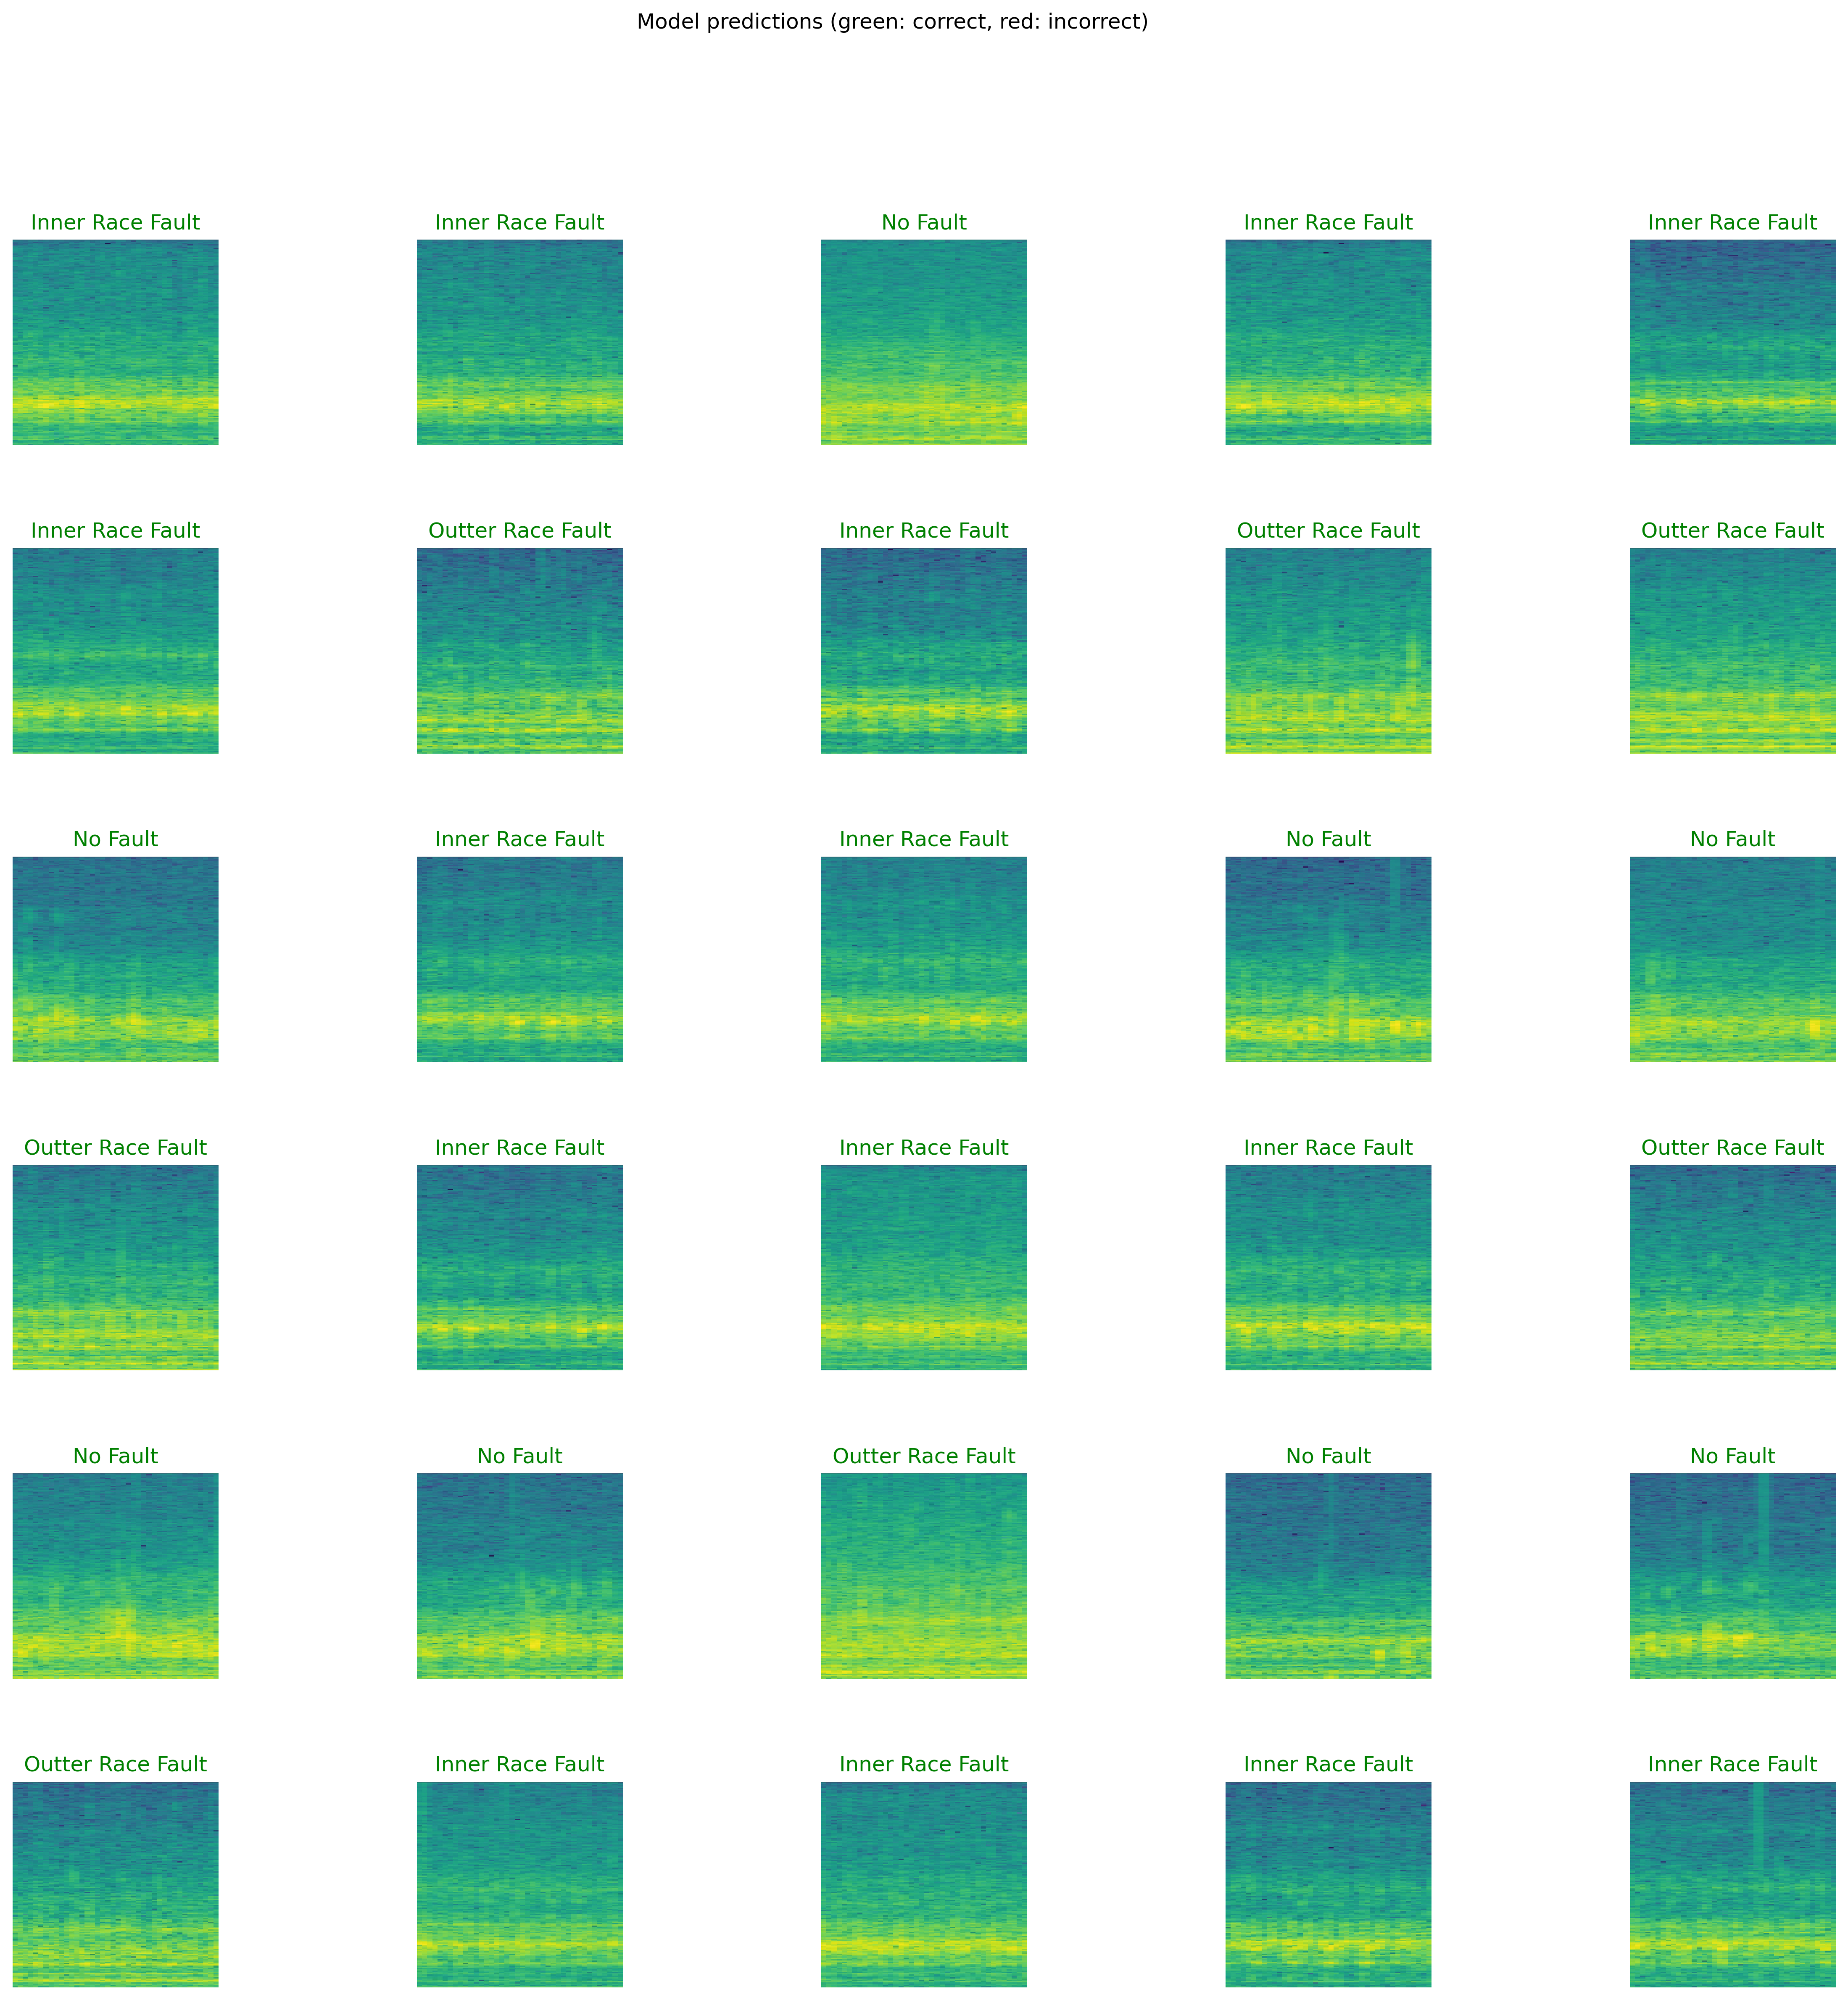

In [ ]:
# Get predictions for each image
predicted_ids = np.argmax(predictions, axis=-1)
predicted_ids = np.array(predicted_ids)
predicted_ids = (list(predicted_ids))
predicted_labels = []
for idx in predicted_ids:
  predicted_labels.append(class_names[idx])


# Print images batch and labels predictions
plt.figure(figsize=(20,18))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n]/255)
  color = "green" if predicted_ids[n] == list(label_batch)[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')
tf.saved_model.save(model,'model')

In [ ]:
#get to the directory with images
saved_model_dir = os.path.join(os.getcwd(),'model')
print(saved_model_dir)

/content/model


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_with_softmax_22032022.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#create a labels file from class_names list

textfile = open("model_labels.txt", "w")
for element in class_names:
    textfile.write(element + "\n")
textfile.close()
